<a href="https://colab.research.google.com/github/iishutov/CV-Project/blob/batch-size-study/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, regularizers
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
train_dir_zip = '/content/drive/MyDrive/ML/my-dataset/train.zip'
test_dir_zip = '/content/drive/MyDrive/ML/my-dataset/test.zip'

train_dir = '/content/train'
test_dir = '/content/test'

batch_size = 16
rescale = 1./255
img_height = img_width = 64

In [3]:
# import folders with dataset and unzip them.
with zipfile.ZipFile(train_dir_zip, 'r') as zip_ref:
    zip_ref.extractall(train_dir)
with zipfile.ZipFile(test_dir_zip, 'r') as zip_ref:
    zip_ref.extractall(test_dir)

In [4]:
# Training dataset preprocessing
train_datagen = ImageDataGenerator(
    rescale=rescale,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42,
)

Found 633 images belonging to 2 classes.


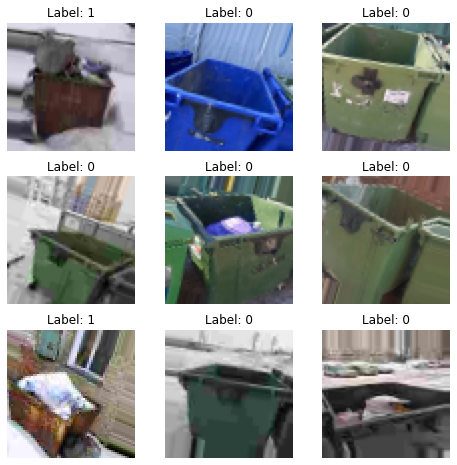

In [5]:
# Show the resulted training dataset after augmentation.
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        image, label = train_dataset.next()
        axs[i,j].imshow(image[0])
        axs[i,j].set_title(f'Label: {(int)(label[0])}')
        axs[i,j].axis('off')
plt.show()

In [6]:
# ImageDataGenerator does not increase the size of the dataset.
train_dataset.n

633

In [7]:
# Testing dataset preprocessing (normalization).
test_datagen = ImageDataGenerator(rescale=rescale)

test_dataset = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 160 images belonging to 2 classes.


In [8]:
# Building the convolutional base.
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
# Adding Dense Layers.
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

Epoch 1/30
40/40 [==============================] - 11s 231ms/step - loss: 0.4086 - accuracy: 0.8515 - val_loss: 0.4186 - val_accuracy: 0.8000
Epoch 2/30
40/40 [==============================] - 9s 209ms/step - loss: 0.3719 - accuracy: 0.8610 - val_loss: 0.4147 - val_accuracy: 0.8062
Epoch 3/30
40/40 [==============================] - 10s 255ms/step - loss: 0.3483 - accuracy: 0.8673 - val_loss: 0.4080 - val_accuracy: 0.8188
Epoch 4/30
40/40 [==============================] - 9s 222ms/step - loss: 0.3562 - accuracy: 0.8610 - val_loss: 0.4825 - val_accuracy: 0.7875
Epoch 5/30
40/40 [==============================] - 9s 227ms/step - loss: 0.3542 - accuracy: 0.8626 - val_loss: 0.4853 - val_accuracy: 0.7937
Epoch 6/30
40/40 [==============================] - 10s 251ms/step - loss: 0.3802 - accuracy: 0.8389 - val_loss: 0.4031 - val_accuracy: 0.8313
Epoch 7/30
40/40 [==============================] - 9s 215ms/step - loss: 0.3460 - accuracy: 0.8768 - val_loss: 0.4099 - val_accuracy: 0.8125
Epo

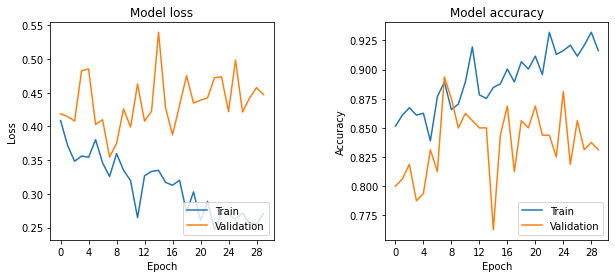

In [10]:
# Training the model.
model.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

history = model.fit(train_dataset, epochs=30, validation_data=test_dataset)
#

# Visualizing loss and accuracy.
fig, (axs_loss, axs_acc) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axs_loss.set_title('Model loss')
axs_loss.set_ylabel('Loss')
axs_loss.set_xlabel('Epoch')
axs_loss.plot(history.history['loss'], label='Train')
axs_loss.plot(history.history['val_loss'], label='Validation')
axs_loss.legend(loc='lower right')
axs_loss.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axs_acc.set_title('Model accuracy')
axs_acc.set_ylabel('Accuracy')
axs_acc.set_xlabel('Epoch')
axs_acc.plot(history.history['accuracy'], label='Train')
axs_acc.plot(history.history['val_accuracy'], label='Validation')
axs_acc.legend(loc='lower right')
axs_acc.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

fig.subplots_adjust(wspace=0.5)
plt.show()

10/10 [==============================] - 1s 94ms/step


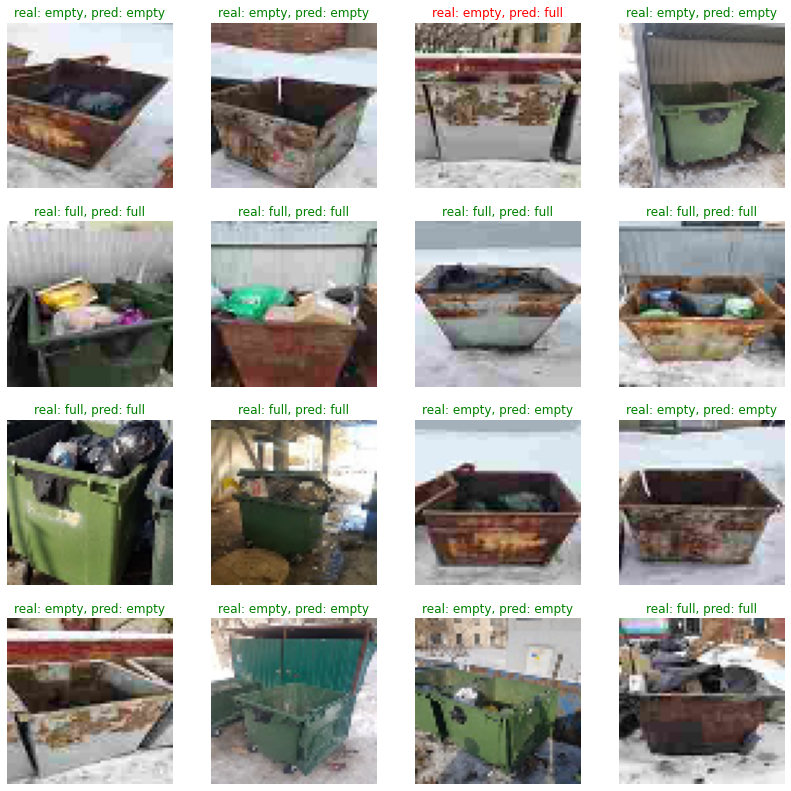

In [11]:
# Result.
predictions = model.predict(test_dataset)

idx = 0
rng = np.random.default_rng()
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(14,14))

for i in range(4):
  for j in range(4):
    image, label = test_dataset.next()
    _batch_size = label.shape[0]
    
    local_idx = (int)(_batch_size * rng.uniform())
    global_idx = (idx + local_idx) % len(predictions)

    real_class = 'full' if np.round(label[local_idx]) else 'empty'
    predicted_class = 'full' if np.round(predictions[global_idx][0]) else 'empty'

    axs[i,j].set_title(f'real: {real_class}, pred: {predicted_class}')\
      .set_color('green' if real_class == predicted_class else 'red')
    axs[i,j].imshow(image[local_idx])
    axs[i,j].axis('off')

    idx += _batch_size

plt.show()